In [44]:
from __future__ import division, print_function, absolute_import

from tmm import (coh_tmm, color, unpolarized_RT, ellips,
                       position_resolved, find_in_structure_with_inf)

import numpy as np
import tmm
from numpy import pi, linspace, inf, array, arange
import pandas as pd  
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import math

%matplotlib inline

degree = pi/180

In [28]:
def position_resolved2(layer, distance, coh_tmm_data):
    """
    Starting with output of coh_tmm(), calculate the Poynting vector,
    absorbed energy density, and E-field at a specific location. The
    location is defined by (layer, distance), defined the same way as in
    find_in_structure_with_inf(...).

    Returns a dictionary containing:

    * poyn - the component of Poynting vector normal to the interfaces
    * absor - the absorbed energy density at that point
    * Ex and Ey and Ez - the electric field amplitudes, where
      z is normal to the interfaces and the light rays are in the x,z plane.

    The E-field is in units where the incoming |E|=1; see
    https://arxiv.org/pdf/1603.02720.pdf for formulas.
    """
    if layer > 0:
        v,w = coh_tmm_data['vw_list'][layer]
    else:
        v = 1
        w = coh_tmm_data['r']
    kz = coh_tmm_data['kz_list'][layer]
    th = coh_tmm_data['th_list'][layer]
    n = coh_tmm_data['n_list'][layer]
    n_0 = coh_tmm_data['n_list'][0]
    th_0 = coh_tmm_data['th_0']
    pol = coh_tmm_data['pol']

    #assert ((layer >= 1 and 0 <= distance <= coh_tmm_data['d_list'][layer])
     #           or (layer == 0 and distance <= 0))

    # Amplitude of forward-moving wave is Ef, backwards is Eb
    Ef = v * np.exp(1j * kz * distance)
    Eb = w * np.exp(-1j * kz * distance)

    # Poynting vector
    if pol == 's':
        poyn = ((n*np.cos(th)*np.conj(Ef+Eb)*(Ef-Eb)).real) / (n_0*np.cos(th_0)).real
    elif pol == 'p':
        poyn = (((n*np.conj(np.cos(th))*(Ef+Eb)*np.conj(Ef-Eb)).real)
                    / (n_0*np.conj(np.cos(th_0))).real)

    # Absorbed energy density
    if pol == 's':
        absor = (n*np.cos(th)*kz*np.abs(Ef+Eb)**2).imag / (n_0*np.cos(th_0)).real
    elif pol == 'p':
        absor = (n*np.conj(np.cos(th))*
                 (kz*np.abs(Ef-Eb)**2-np.conj(kz)*np.abs(Ef+Eb)**2)
                ).imag / (n_0*np.conj(np.cos(th_0))).real

    # Electric field
    if pol == 's':
        Ex = 0
        Ey = Ef + Eb
        Ez = 0
    elif pol == 'p':
        Ex = (Ef - Eb) * np.cos(th)
        Ey = 0
        Ez = (-Ef - Eb) * np.sin(th)

    return {'poyn': poyn, 'absor': absor, 'Ex': Ex, 'Ey': Ey, 'Ez': Ez}

In [29]:
Ag  = pd.read_table("C:\\Users\AdminTechnik\\Documents\\Python\\Ag.txt")
#set values for the wavelengths,n,k of Ag
n_Ag=Ag.iloc[:,1]
wl_Ag = Ag.iloc[:,0]
k_Ag=Ag.iloc[:,2]

#create array for silver 
#first set an empty complex array 
material_nk_data = np.zeros((len(wl_Ag),2),dtype=complex)

for i in range(len(wl_Ag)):
    material_nk_data[i,0] = complex(wl_Ag.iloc[i],0)
    material_nk_data[i,1] = complex(n_Ag.iloc[i],k_Ag.iloc[i])

In [30]:
Si  = pd.read_table("C:\\Users\AdminTechnik\\Documents\\Python\\Si.txt")
#set values for the wavelengths,n,k of Si
n_Si=Si.iloc[:,1]
wl_Si = Si.iloc[:,0]
k_Si=Si.iloc[:,2]

#create array for si
#first set an empty complex array 
material_nk_data_Si = np.zeros((len(wl_Si),2),dtype=complex)

for i in range(len(wl_Si)):
    material_nk_data_Si[i,0] = complex(wl_Si.iloc[i],0)
    material_nk_data_Si[i,1] = complex(n_Si.iloc[i],k_Si.iloc[i])

In [31]:
Gr  = pd.read_table("C:\\Users\AdminTechnik\\Documents\\Python\\Gr.txt", encoding="utf8")
#encoded from a .csv --> .txt MS DOS 
#set values for the wavelengths,n,k of graphene
n_Gr=Gr.iloc[:,1]
wl_Gr = Gr.iloc[:,0]
k_Gr=Gr.iloc[:,2]

#create array for graphene 
#first set an empty complex array 
material_nk_data_Gr = np.zeros((len(wl_Gr),2),dtype=complex)

for i in range(len(wl_Gr)):
    material_nk_data_Gr[i,0] = complex(wl_Gr.iloc[i],0)
    material_nk_data_Gr[i,1] = complex(n_Gr.iloc[i],k_Gr.iloc[i])

In [32]:
SiO2  = pd.read_table("C:\\Users\AdminTechnik\\Documents\\Python\\SiO2.txt")
#set values for the wavelengths,n,k of SiO2
n_SiO2=SiO2.iloc[:,1]
wl_SiO2 = SiO2.iloc[:,0]
k_SiO2=SiO2.iloc[:,2]

#create array for sio2 
#first set an empty complex array 
material_nk_data_SiO2 = np.zeros((len(wl_SiO2),2),dtype=complex)

for i in range(len(wl_SiO2)):
    material_nk_data_SiO2[i,0] = complex(wl_SiO2.iloc[i],0)
    material_nk_data_SiO2[i,1] = complex(n_SiO2.iloc[i],k_SiO2.iloc[i])
    


In [33]:
Al2O3  = pd.read_table("C:\\Users\AdminTechnik\\Documents\\Python\\Al2O3.txt", encoding="utf8")
#set values for the wavelengths,n,k of Al2O3
n_Al2O3=Al2O3.iloc[:,1]
wl_Al2O3 = Al2O3.iloc[:,0]
k_Al2O3=Al2O3.iloc[:,2]

#create array for Al2O3 
#first set an empty complex array 
material_nk_data_Al2O3 = np.zeros((len(wl_Al2O3),2),dtype=complex)

for i in range(len(wl_Al2O3)):
    material_nk_data_Al2O3[i,0] = complex(wl_Al2O3.iloc[i],0)
    material_nk_data_Al2O3[i,1] = complex(n_Al2O3.iloc[i],k_Al2O3.iloc[i])

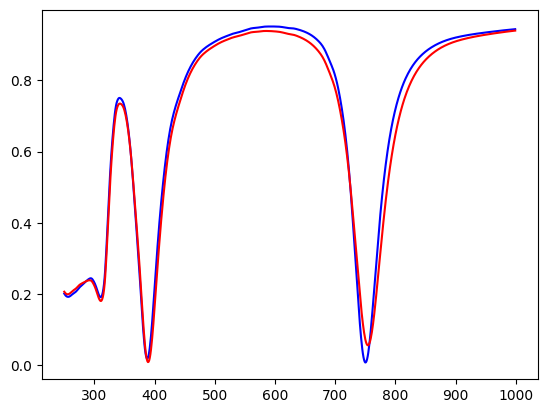

In [108]:

material_nk_fn = interp1d(material_nk_data[:,0].real,
    material_nk_data[:,1], kind='quadratic')

material_nk_fn_Si = interp1d(material_nk_data_Si[:,0].real,
    material_nk_data_Si[:,1], kind='quadratic')

material_nk_fn_SiO2 = interp1d(material_nk_data_SiO2[:,0].real,
    material_nk_data_SiO2[:,1], kind='quadratic')

material_nk_fn_Al2O3 = interp1d(material_nk_data_Al2O3[:,0].real,
    material_nk_data_Al2O3[:,1], kind='quadratic')

material_nk_fn_Gr = interp1d(material_nk_data_Gr[:,0].real,
    material_nk_data_Gr[:,1], kind='quadratic')

#d_list = [inf,30,80,40,40,100,90,inf]
air_n_fn = lambda wavelength : 1

#n_fn_list = [air_n_fn, material_nk_fn,material_nk_fn_Al2O3, material_nk_fn_Al2O3, material_nk_fn_Al2O3, material_nk_fn, material_nk_fn_SiO2,material_nk_fn_Si]
d_list = [inf,
          22,
          80,
          
          40,
          
          40,
          100,
          90,
          inf]

n_fn_list = [air_n_fn, 
            material_nk_fn,
            material_nk_fn_Al2O3,
            
            material_nk_fn_Al2O3,
            
            material_nk_fn_Al2O3, 
            material_nk_fn, 
            material_nk_fn_SiO2,
            air_n_fn]

d_list_Gr = [inf,
          22,
          80,
          0.335,
          40,
          0.335,
          40,
          100,
          90,
          inf]

n_fn_list_Gr = [air_n_fn, 
            material_nk_fn,
            material_nk_fn_Al2O3,
            material_nk_fn_Gr, 
            material_nk_fn_Al2O3,
            material_nk_fn_Gr, 
            material_nk_fn_Al2O3, 
            material_nk_fn, 
            material_nk_fn_SiO2,
            air_n_fn]

R=[] 
T=[]
R_Gr=[] 
T_Gr=[]

coh_tmm_data=[]

coh_tmm_data_Gr=[]
#todo. CHECK THE MAX RANGE OF WAVELENGHTS now it is important to give a range inside all the files wavlenghts range


lambda_vac_list = arange(250,1000)
num_layers = len(n_fn_list)
num_layers_Gr = len(n_fn_list_Gr)
#Incidence angle
th_0=0
for lam_vac in lambda_vac_list:
    # For normal incidence, s and p polarizations are identical.
    n_list = [n_fn_list[i](lam_vac) for i in range(num_layers)]
    R.append(coh_tmm('s',n_list, d_list, th_0, lam_vac)['R'])
    T.append(coh_tmm('s',n_list, d_list, th_0, lam_vac)['T'])
    
    #coh_tmm calculates data for every wl
    coh_tmm_data.append(coh_tmm('p',n_list,d_list,th_0,lam_vac))
    

    n_list_Gr = [n_fn_list_Gr[i](lam_vac) for i in range(num_layers_Gr)]
    R_Gr.append(coh_tmm('s',n_list_Gr, d_list_Gr, th_0, lam_vac)['R'])
    T_Gr.append(coh_tmm('s',n_list_Gr, d_list_Gr, th_0, lam_vac)['T'])      
    coh_tmm_data_Gr.append(coh_tmm('p',n_list_Gr,d_list_Gr,th_0,lam_vac))
    
plt.figure()
plt.plot(lambda_vac_list,R,'blue')
plt.plot(lambda_vac_list,R_Gr,'red')



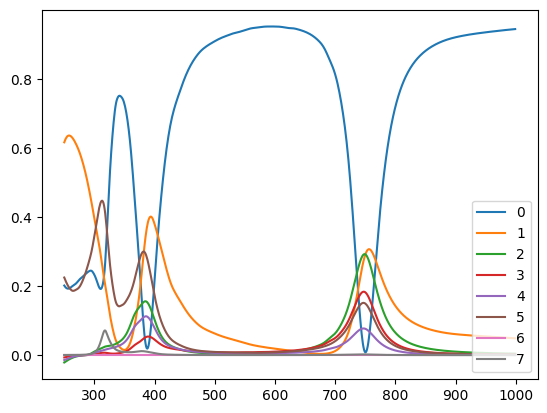

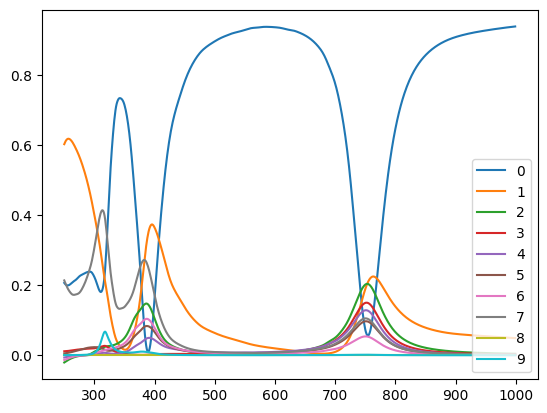

In [76]:
A = []
A_Gr = []
for lam_vac_2 in range(len(coh_tmm_data)):
    A.append(tmm.absorp_in_each_layer(coh_tmm_data[lam_vac_2]))
    A_Gr.append(tmm.absorp_in_each_layer(coh_tmm_data_Gr[lam_vac_2]))
    

plt.figure()
plt.plot(lambda_vac_list,A)
plt.legend(range(0,len(d_list)),loc="lower right") 

plt.figure()
plt.plot(lambda_vac_list,A_Gr)
plt.legend(range(0,len(d_list_Gr)),loc="lower right") 


In [ ]:
Abs_Gr_1=[]
Abs_Gr_2=[]
for lam_vac_2 in range(len(A_Gr)):
    Abs_Gr_1.append(A_Gr[lam_vac_2][3])
    Abs_Gr_2.append(A_Gr[lam_vac_2][5])

plt.figure()
plt.plot(lambda_vac_list,Abs_Gr_1)
plt.plot(lambda_vac_list,Abs_Gr_2)

In [114]:
#this Block calculate the thickness of the top mirror with highest ABS for Graphene
air_n_fn = lambda wavelength : 1
thick_Ag = range(1,50)

R_diff=[]
Abs_peak_1=[]
Abs_peak_2=[]
for nm in thick_Ag:

        d_list = [inf,
                nm,
                80,
                
                40,
                
                40,
                100,
                90,
                inf]

        n_fn_list = [air_n_fn, 
                        material_nk_fn,
                        material_nk_fn_Al2O3,
                        
                        material_nk_fn_Al2O3,
                        
                        material_nk_fn_Al2O3, 
                        material_nk_fn, 
                        material_nk_fn_SiO2,
                        air_n_fn]

        d_list_Gr = [inf,
                nm,
                80,
                0.335,
                40,
                0.335,
                40,
                100,
                90,
                inf]

        n_fn_list_Gr = [air_n_fn, 
                        material_nk_fn,
                        material_nk_fn_Al2O3,
                        material_nk_fn_Gr, 
                        material_nk_fn_Al2O3,
                        material_nk_fn_Gr, 
                        material_nk_fn_Al2O3, 
                        material_nk_fn, 
                        material_nk_fn_SiO2,
                        air_n_fn]

        R=[] 
        T=[]
        R_Gr=[] 
        T_Gr=[]
        R_diff_list=[]

        coh_tmm_data=[]

        coh_tmm_data_Gr=[]
        #todo. CHECK THE MAX RANGE OF WAVELENGHTS now it is important to give a range inside all the files wavlenghts range


        lambda_vac_list = arange(250,1000)
        num_layers = len(n_fn_list)
        num_layers_Gr = len(n_fn_list_Gr)
        #Incidence angle
        th_0=0
        for lam_vac in lambda_vac_list:
                # For normal incidence, s and p polarizations are identical.
                n_list = [n_fn_list[i](lam_vac) for i in range(num_layers)]
                R.append(coh_tmm('s',n_list, d_list, th_0, lam_vac)['R'])
                T.append(coh_tmm('s',n_list, d_list, th_0, lam_vac)['T'])
        
                #coh_tmm calculates data for every wl
                coh_tmm_data.append(coh_tmm('p',n_list,d_list,th_0,lam_vac))
        
                n_list_Gr = [n_fn_list_Gr[i](lam_vac) for i in range(num_layers_Gr)]
                R_Gr.append(coh_tmm('s',n_list_Gr, d_list_Gr, th_0, lam_vac)['R'])
                T_Gr.append(coh_tmm('s',n_list_Gr, d_list_Gr, th_0, lam_vac)['T'])      
                coh_tmm_data_Gr.append(coh_tmm('p',n_list_Gr,d_list_Gr,th_0,lam_vac))
                
        #A = []
        R_diff.append(R_Gr[749-250]-R[749-250])
        A_Gr = []
                
        for lam_vac_2 in range(len(coh_tmm_data)):
                #A.append(tmm.absorp_in_each_layer(coh_tmm_data[lam_vac_2]))
                A_Gr.append(tmm.absorp_in_each_layer(coh_tmm_data_Gr[lam_vac_2]))

        Abs_peak_1.append(A_Gr[749-250][3])
        Abs_peak_2.append(A_Gr[749-250][5])
        print(nm)



1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


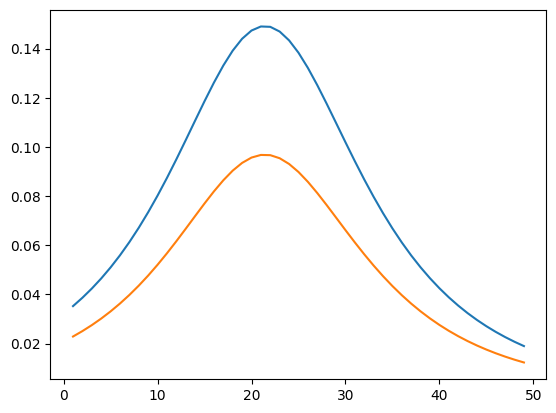

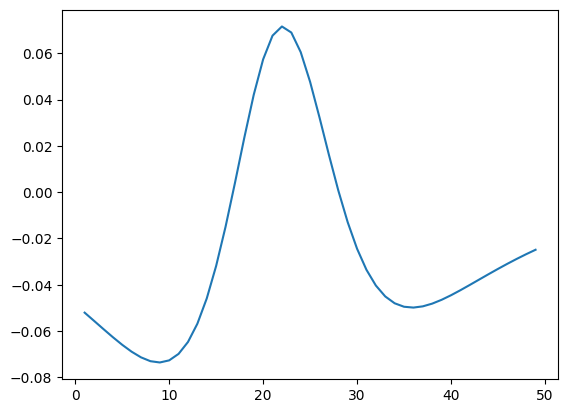

In [115]:
#PLOT ABS peaks for the two graphene layers
plt.figure()
plt.plot(thick_Ag,Abs_peak_1)
plt.plot(thick_Ag,Abs_peak_2)

#Plot difference reflectivity with and without Graphene
plt.figure()
plt.plot(thick_Ag,R_diff)


c:\Users\AdminTechnik\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)


ValueError: x and y must have same first dimension, but have shapes (750,) and (1, 6)

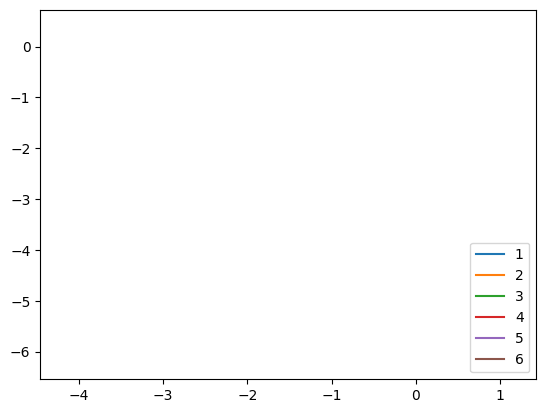

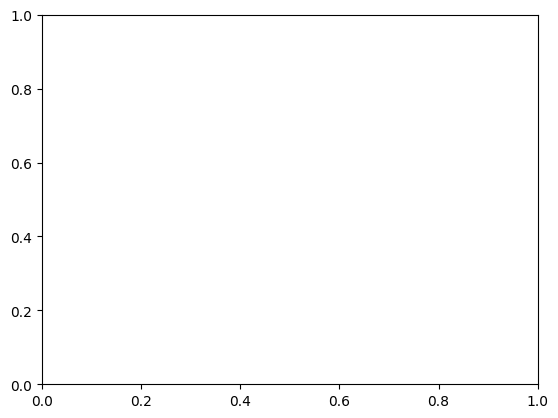

In [91]:
E=np.zeros((len(coh_tmm_data),(len(d_list)-2)), dtype=complex)
#E=np.zeros((8,750),dtype=complex)

thick=[]
thick = d_list[1:len(d_list)-1]
for d in range(len(thick)-1):

    for lam_vac_2 in range(len(coh_tmm_data)):
    
        E[lam_vac_2][d]= position_resolved2(d,thick[d],coh_tmm_data[lam_vac_2])['Ex']
        


plt.figure()

plt.plot(E.real,E.imag)
plt.legend(range(1,len(d_list)),loc="lower right") 

plt.figure()
plt.plot(lambda_vac_list,E)
plt.legend(range(1,len(d_list)),loc="lower right")

plt.figure()
plt.plot(lambda_vac_list,E.imag)
plt.legend(range(1,len(d_list)),loc="lower right")